In [1]:
!pip install keras_tuner

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.5/129.5 kB 2.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 950.8/950.8 kB 25.7 MB/s eta 0:00:00


In [2]:
# 导包
!pip install keras_tuner
import os
import json
import shutil
import numpy as np
import keras_tuner as kt
from tensorflow import keras
import tensorflow as tf
from kerastuner.tuners import RandomSearch
from kerastuner.engine.hyperparameters import HyperParameter as hp
from keras.layers import Dense, Dropout, Activation, Add, MaxPooling2D, Conv2D, Flatten, BatchNormalization
from keras.models import Sequential
from keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt
from keras.applications import VGG16
from tensorflow.keras.applications import InceptionV3
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
import seaborn as sns
from PIL import Image
from matplotlib.font_manager import FontProperties
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import EarlyStopping, CSVLogger, ModelCheckpoint

%matplotlib inline
%config InlineBackend.figure_format = 'svg'

Using TensorFlow backend


<ipython-input-2-b1a8cb481bdd>:10: DeprecationWarning: `import kerastuner` is deprecated, please use `import keras_tuner`.
  from kerastuner.tuners import RandomSearch


In [ ]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Not connected to a GPU')
else:
  print(gpu_info)

In [ ]:
from psutil import virtual_memory
ram_gb = virtual_memory().total / 1e9
print('Your runtime has {:.1f} gigabytes of available RAM\n'.format(ram_gb))

if ram_gb < 20:
  print('Not using a high-RAM runtime')
else:
  print('You are using a high-RAM runtime!')

In [7]:
# 下载数据集
!git clone -b trian --single-branch https://github.com/CHATWA/MotherCup.git

Cloning into 'MotherCup'...
remote: Enumerating objects: 2105, done.
remote: Counting objects: 100% (1878/1878), done.
remote: Compressing objects: 100% (1869/1869), done.
remote: Total 2105 (delta 7), reused 1877 (delta 7), pack-reused 227
Receiving objects: 100% (2105/2105), 2.24 GiB | 23.67 MiB/s, done.
Resolving deltas: 100% (7/7), done.
Updating files: 100% (1055/1055), done.


In [ ]:
!git clone https://e.coding.net/g-hymp8005/example-project/MotherCupData.git

In [8]:
os.chdir(r'./MotherCup')

In [9]:
with open('class_indices.json', 'r') as f:
  class_indices = json.load(f)


# 创建训练数据生成器并进行数据增强和预处理
train_datagen = ImageDataGenerator(
  rescale=1 / 255,  # 像素值缩放到 [0,1] 范围内
  shear_range=0.2,  # 随机剪切变换的角度范围
  zoom_range=0.25,  # 随机缩放变换的范围
  vertical_flip=True,  # 垂直翻转
  horizontal_flip=True,  # 水平翻转
  rotation_range=45,  # 随机旋转的角度范围
  brightness_range=(0.45, 1.95),  # 随机调整亮度
  width_shift_range=0.15,  # 水平位移范围
  height_shift_range=0.15,  # 垂直位移范围
  channel_shift_range=0.2,  # 随机通道移动
  preprocessing_function=tf.keras.applications.vgg16.preprocess_input
)

# 从目录加载训练数据并应用数据生成器
train_data = train_datagen.flow_from_directory(
  './data/train',  # 训练数据目录路径
  target_size=(299, 299),# 调整图像大小
  class_mode='sparse',  # 目标变量是稀疏标签
  shuffle=True,  # 是否随机打乱样本顺序
  seed=1,  # 随机数种子，用于复现性
  classes=class_indices.keys()  # 加载自定义的类别编号映射
)

# 创建测试数据生成器并进行预处理
test_datagen = ImageDataGenerator(
    rescale=1 / 255,  # 像素值缩放到 [0,1] 范围内
    shear_range=0.3,  # 随机剪切变换的角度范围
    zoom_range=0.35,  # 随机缩放变换的范围
    rotation_range=50,  # 随机旋转的角度范围
    brightness_range=(0.2, 1.9),  # 随机调整亮度
    width_shift_range=0.2,  # 水平位移范围
    height_shift_range=0.2,  # 垂直位移范围
    channel_shift_range=0.25,  # 随机通道移动
    preprocessing_function=tf.keras.applications.vgg16.preprocess_input
)

# 从目录加载测试数据并应用数据生成器
test_data = test_datagen.flow_from_directory(
  "./data/val",  # 测试数据目录路径
  target_size=(299, 299),  # 调整图像大小
  class_mode='sparse',  # 目标变量是稀疏标签
  shuffle=True,     # 是否随机打乱样本顺序
  seed=1,        # 随机数种子，用于复现性
  classes=class_indices.keys()  # 加载自定义的类别编号映射
)

Found 892 images belonging to 2 classes.
Found 160 images belonging to 2 classes.


# 编码

In [10]:
print(train_data.class_indices)

{'normal': 0, 'potholes': 1}


# 构建网络模型

In [11]:
# 加载预训练的InceptionV3模型
inception_model = InceptionV3(weights='imagenet', include_top=False)

# 冻结模型的所有层，以便保持其权重不变
for layer in inception_model.layers:
  layer.trainable = False

# 添加自定义的全局平均池化层
model = Sequential()
model.add(inception_model)
model.add(tf.keras.layers.GlobalAveragePooling2D())

# 添加全连接层，其中每一层后面都有一个Dropout层用于防止过拟合
model.add(Dense(2048, activation='relu', kernel_regularizer=l2(0.001)))  # 添加L2正则化项
model.add(Dropout(0.35))
model.add(Dense(1024, activation='relu', kernel_regularizer=l2(0.001)))  # 添加L2正则化项
model.add(Dropout(0.3))
model.add(Dense(512, activation='relu', kernel_regularizer=l2(0.001)))  # 添加L2正则化项
model.add(Dropout(0.25))
model.add(Dense(256, activation='relu', kernel_regularizer=l2(0.001)))  # 添加L2正则化项
model.add(Dropout(0.2))

# 添加最终输出层，这里是一个具有两个类别的分类器
model.add(Dense(2, activation='softmax'))

# 打印模型的详细信息
model.summary()
# 编译模型
model.compile(optimizer='adam', loss=keras.losses.SparseCategoricalCrossentropy(), metrics=['accuracy'])

87910968/87910968 [==============================] - 4s 0us/step
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 inception_v3 (Functional)   (None, None, None, 2048   21802784  
                             )                                   
                                                                 
 global_average_pooling2d (  (None, 2048)              0         
 GlobalAveragePooling2D)                                         
                                                                 
 dense (Dense)               (None, 2048)              4196352   
                                                                 
 dropout (Dropout)           (None, 2048)              0         
                                                                 
 dense_1 (Dense)             (None, 1024)              2098176   
                                                         

In [12]:
point_filepath = './checkpoint/Baseline.ckpt'
bestpoint_filepath = './checkpoint_best/Baseline.ckpt'

In [ ]:
# 断点续训
model.load_weights(point_filepath)

In [13]:
# 设置早停回调函数
early = EarlyStopping(monitor='val_loss', patience=5)

# 实例化ModelCheckpoint
cp_callback_save = ModelCheckpoint(filepath=point_filepath)
class SaveBestModel(tf.keras.callbacks.Callback):
  def __init__(self, filepath):
    super(SaveBestModel, self).__init__()
    self.filepath = filepath
    self.best_val_accuracy = -float('inf')
    self.best_train_accuracy = -float('inf')

  def on_epoch_end(self, epoch, logs=None):
    val_accuracy = logs.get('val_accuracy')
    train_accuracy = logs.get('accuracy')

    if val_accuracy is not None and train_accuracy is not None:
      if val_accuracy > self.best_val_accuracy and train_accuracy > self.best_train_accuracy:
        self.best_val_accuracy = val_accuracy
        self.best_train_accuracy = train_accuracy
        self.model.save_weights(self.filepath, overwrite=True)
        print(f"\nSaved model with val_accuracy: {val_accuracy} and train_accuracy: {train_accuracy}.")

bestpoint_filepath = './best_model.h5'
cp_callback_save_best = SaveBestModel(filepath=bestpoint_filepath)

history = model.fit(
  train_data,  # 训练数据生成器
  validation_data=test_data,  # 验证数据生成器
  callbacks=[early,cp_callback_save,cp_callback_save_best],  # 使用早停回调
  epochs=300  # 训练的epoch数
)

Epoch 1/300
28/28 [==============================] - ETA: 0s - loss: 4.9331 - accuracy: 0.5168
Saved model with val_accuracy: 0.9125000238418579 and train_accuracy: 0.5168161392211914.
28/28 [==============================] - 125s 4s/step - loss: 4.9331 - accuracy: 0.5168 - val_loss: 3.8530 - val_accuracy: 0.9125
Epoch 2/300
28/28 [==============================] - ETA: 0s - loss: 3.3740 - accuracy: 0.8543
Saved model with val_accuracy: 0.9437500238418579 and train_accuracy: 0.8542600870132446.
28/28 [==============================] - 104s 4s/step - loss: 3.3740 - accuracy: 0.8543 - val_loss: 2.8376 - val_accuracy: 0.9438
Epoch 3/300
28/28 [==============================] - 102s 4s/step - loss: 2.6336 - accuracy: 0.9316 - val_loss: 2.3755 - val_accuracy: 0.9375
Epoch 4/300
28/28 [==============================] - 101s 4s/step - loss: 2.2352 - accuracy: 0.9182 - val_loss: 2.0113 - val_accuracy: 0.9312
Epoch 5/300
28/28 [==============================] - 100s 4s/step - loss: 1.8839 - acc

In [14]:
# 保存整个模型
model.save('my_model_InceptionV3.keras')

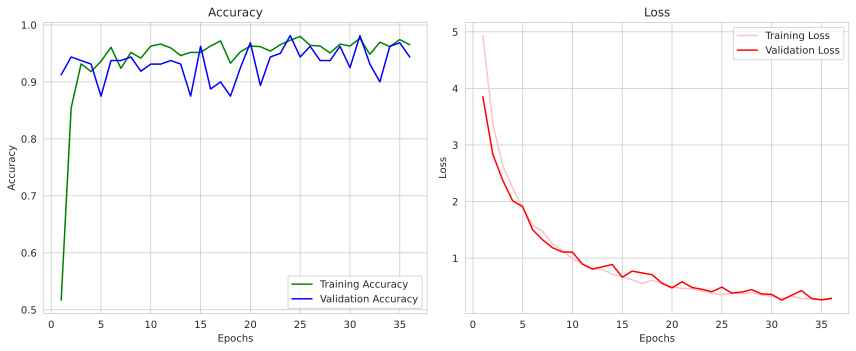

In [15]:
# 绘图
sns.set_style("whitegrid")  # 使用白色背景，并带网格线

# 从训练历史中提取准确度和损失值
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)

# 绘制准确度曲线
plt.figure(figsize=(12, 5))  # 设置整体图表大小
plt.subplot(1, 2, 1)  # 创建一个1行2列的子图，进入第1个子图
plt.plot(epochs, acc, color='green', label='Training Accuracy')  # 训练集准确度
plt.plot(epochs, val_acc, color='blue', label='Validation Accuracy')  # 验证集准确度
plt.xticks(range(min(epochs)-1, max(epochs)+1, 5))
plt.title('Accuracy')  # 图表标题
plt.ylabel('Accuracy')  # y轴标签
plt.xlabel('Epochs')  # x轴标签
plt.legend()  # 添加图例

# 绘制损失曲线
plt.subplot(1, 2, 2)  # 进入第2个子图
plt.plot(epochs, loss, color='pink', label='Training Loss')  # 训练集损失
plt.plot(epochs, val_loss, color='red', label='Validation Loss')  # 验证集损失
plt.xticks(range(min(epochs)-1, max(epochs)+1, 5))
plt.title('Loss')  # 图表标题
plt.xlabel('Epochs')  # x轴标签
plt.ylabel('Loss')  # y轴标签
plt.legend()  # 添加图例

plt.tight_layout()  # 调整子图之间的间距
plt.savefig('jieguotu.png')
plt.show()

In [16]:
# 加载模型权重
from tensorflow.keras.models import load_model

model = load_model('my_model_InceptionV3.keras')
model.load_weights('best_model.h5')
# 打印模型的详细信息
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 inception_v3 (Functional)   (None, None, None, 2048   21802784  
                             )                                   
                                                                 
 global_average_pooling2d (  (None, 2048)              0         
 GlobalAveragePooling2D)                                         
                                                                 
 dense (Dense)               (None, 2048)              4196352   
                                                                 
 dropout (Dropout)           (None, 2048)              0         
                                                                 
 dense_1 (Dense)             (None, 1024)              2098176   
                                                                 
 dropout_1 (Dropout)         (None, 1024)              0

In [34]:
from sklearn.metrics import classification_report

# 创建测试数据生成器并进行预处理
test_datagen = ImageDataGenerator(
    rescale=1 / 255,  # 像素值缩放到 [0,1] 范围内
    shear_range=0.3,  # 随机剪切变换的角度范围
    zoom_range=0.35,  # 随机缩放变换的范围
    rotation_range=50,  # 随机旋转的角度范围
    brightness_range=(0.2, 1.9),  # 随机调整亮度
    width_shift_range=0.2,  # 水平位移范围
    height_shift_range=0.2,  # 垂直位移范围
    channel_shift_range=0.25,  # 随机通道移动
)

# 从目录加载测试数据并应用数据生成器
test_data = test_datagen.flow_from_directory(
  "./data/val",
  target_size=(299, 299),
  class_mode='sparse',
  shuffle=False,  # 不需要打乱样本顺序，因为我们要计算评估指标
  seed=1,
  classes=class_indices.keys()  # 加载自定义的类别编号映射
)

# 预测测试集
y_true = test_data.classes
y_pred_prob = model.predict(test_data)
y_pred = np.argmax(y_pred_prob,axis=1)

# 计算评估指标
accuracy = tf.reduce_mean(tf.cast(tf.equal(y_true, y_pred), dtype=tf.float32))

# 计算分类报告
classification_rep = classification_report(y_true, y_pred, target_names=class_indices.keys())

print(f'Accuracy: {accuracy.numpy()}')
print(f'Classification Report:\n{classification_rep}')

Found 160 images belonging to 2 classes.
5/5 [==============================] - 11s 2s/step
Accuracy: 0.9125000238418579
Classification Report:
              precision    recall  f1-score   support

      normal       0.93      0.89      0.91        80
    potholes       0.89      0.94      0.91        80

    accuracy                           0.91       160
   macro avg       0.91      0.91      0.91       160
weighted avg       0.91      0.91      0.91       160



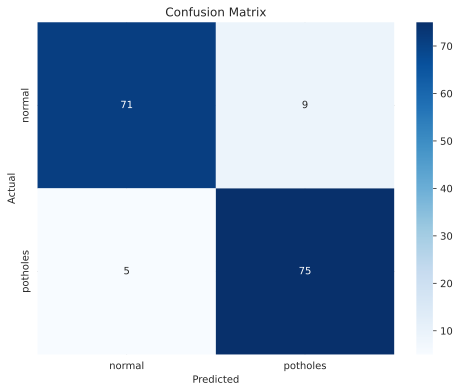

In [33]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# 计算混淆矩阵
conf_mat = confusion_matrix(y_true, y_pred)

# 绘制混淆矩阵
plt.figure(figsize=(8, 6))
sns.heatmap(conf_mat, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_indices.keys(),
            yticklabels=class_indices.keys())
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()


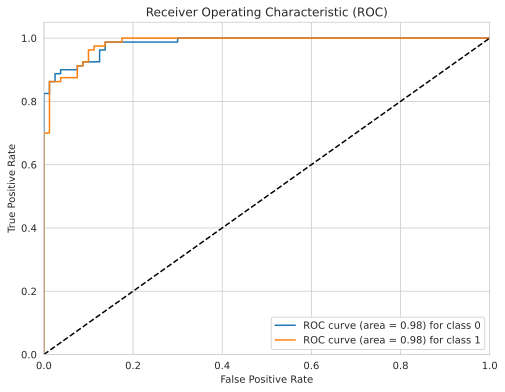

In [31]:
from sklearn.metrics import roc_curve, auc

# 计算每个类别的ROC曲线和AUC
fpr, tpr, roc_auc = {}, {}, {}
for i in range(len(class_indices)):
    fpr[i], tpr[i], _ = roc_curve(y_true, y_pred_prob[:, i], pos_label=i)
    roc_auc[i] = auc(fpr[i], tpr[i])

# 绘制ROC曲线
plt.figure(figsize=(8, 6))
for i in range(len(class_indices)):
    plt.plot(fpr[i], tpr[i], label=f'ROC curve (area = {roc_auc[i]:.2f}) for class {i}')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC)')
plt.legend(loc="lower right")
plt.show()


In [27]:
print(y_pred_prob)

[[9.99285161e-01 7.14889728e-04]
 [4.72415149e-01 5.27584851e-01]
 [9.98878539e-01 1.12139643e-03]
 [9.98418808e-01 1.58121844e-03]
 [9.96558011e-01 3.44193541e-03]
 [2.50884295e-01 7.49115705e-01]
 [9.86406863e-01 1.35931950e-02]
 [9.97794986e-01 2.20505637e-03]
 [9.86453712e-01 1.35462871e-02]
 [9.99754846e-01 2.45152711e-04]
 [9.95727897e-01 4.27212520e-03]
 [9.99008775e-01 9.91240959e-04]
 [9.99684215e-01 3.15794081e-04]
 [9.98034775e-01 1.96520751e-03]
 [9.99677896e-01 3.22123436e-04]
 [9.85254109e-01 1.47459097e-02]
 [9.88516688e-01 1.14833005e-02]
 [9.63104784e-01 3.68951596e-02]
 [1.78527683e-01 8.21472287e-01]
 [8.40308487e-01 1.59691468e-01]
 [9.97933030e-01 2.06695776e-03]
 [9.99733865e-01 2.66146031e-04]
 [8.98642063e-01 1.01357907e-01]
 [9.63442385e-01 3.65575999e-02]
 [9.95585918e-01 4.41412022e-03]
 [9.95132744e-01 4.86724637e-03]
 [9.99462783e-01 5.37200016e-04]
 [9.98120606e-01 1.87934656e-03]
 [9.81869757e-01 1.81302559e-02]
 [2.34241225e-02 9.76575851e-01]
 [9.985331